# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [ ]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug;


In [ ]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import pandas as pd
import numpy as np

from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from PIL import Image

plt.style.use('ggplot')

In [ ]:
# Run this cell to import or install the Data Wrangler widget to show automatic visualization and generate code to fix data quality issues
try:
    import sagemaker_datawrangler;
except ImportError:
    !pip install --upgrade sagemaker-datawrangler
    import sagemaker_datawrangler;

# Display Pandas DataFrame to view the widget: df, display(df), df.sample()... 

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [68]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
#!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
#!unzip dogImages.zip

#Using the Caltech-256 data for image classification 
#Full details can be found here: https://paperswithcode.com/dataset/caltech-256
import os
import urllib
from torchvision.datasets import MNIST
from torchvision import transforms
sagemaker_session = sagemaker.Session()
bucket = 'calvin-wright-udactiy-awsml'
prefix = "image-classifier-project"

role = sagemaker.get_execution_role()

local_dir = "data"
MNIST.mirrors = ["https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/"]
MNIST(
    local_dir,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
)

inputs = sagemaker_session.upload_data(path="data", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://calvin-wright-udactiy-awsml/image-classifier-project


In [ ]:
!pygmentize train_model_CW.py

In [ ]:
import logging
import sys
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))
logger.debug("This is {} a test".format("NEW"))

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [ ]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([10, 20, 100, 200, 500]),
    "epochs": IntegerParameter(2, 8)
}

In [ ]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

role = sagemaker.get_execution_role()
#env = {
#    'SAGEMAKER_REQUIREMENTS': 'CRAFT/requirements.txt', # path relative to `source_dir` below.
#}
estimator = PyTorch(
    entry_point="train_model_CW.py",
    role=role,
    py_version="py3",
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.m5.xlarge"
)

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=1,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

In [ ]:
### TODO: Fit your HP Tuner      
tuner.fit({"training": inputs}) # TODO: Remember to include your data channels

...........................

In [29]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()
#print(best_estimator)
#Get the hyperparameters of the best trained model
best_params = best_estimator.hyperparameters()
best_params


2023-07-28 12:55:38 Starting - Preparing the instances for training
2023-07-28 12:55:38 Downloading - Downloading input data
2023-07-28 12:55:38 Training - Training image download completed. Training in progress.
2023-07-28 12:55:38 Uploading - Uploading generated training model
2023-07-28 12:55:38 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"200"',
 'epochs': '2',
 'lr': '0.02111613440485318',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-07-28-12-50-57-975"',
 'sagemaker_program': '"train_model_CW.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-022761975017/pytorch-training-2023-07-28-12-50-57-975/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [22]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [ ]:
#Test
! python train_model_CW.py

Distributed training - False
Number of gpus available - 0
Preparing data
Data dir is:data/MNIST/raw
Namespace(batch_size=64, test_batch_size=1000, epochs=10, lr=0.01, momentum=0.5, seed=1, log_interval=100, backend=None, data_dir='data/MNIST/raw', hosts=[''], current_host='Notebook', model_dir='SM_MODEL_DIR', num_gpus=0)
Get train data loader
100%|██████████████████████████| 9912422/9912422 [00:00<00:00, 282439853.02it/s]
Extracting data/MNIST/raw/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw/MNIST/raw

100%|██████████████████████████████| 28881/28881 [00:00<00:00, 113210928.81it/s]
Extracting data/MNIST/raw/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw/MNIST/raw

100%|██████████████████████████| 1648877/1648877 [00:00<00:00, 202806117.02it/s]
Extracting data/MNIST/raw/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw/MNIST/raw

100%|█████████████████████████████████| 4542/4542 [00:00<00:00, 19721044.27it/s]
Extracting data/MNIST/raw/MNIST/raw/t10k-labels-idx1-uby

In [99]:
# TODO: Create and fit an estimator
#Best params from tuning job
hyperparameter_values = {
    "lr": float(best_params['lr']),
    "batch-size": int(best_params['batch-size'][1:-1])
}

main_dir = "s3://" + bucket + "/" + prefix
os.environ["SM_CHANNEL_TRAINING"] = main_dir
os.environ['SM_MODEL_DIR'] = main_dir + "/MNIST/model-dir/" # where model will be stored

estimator = PyTorch(
    entry_point="train_model_CW.py",
    role=role,
    py_version="py3",
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    hyperparameters=hyperparameter_values,
    output_data_config=os.environ['SM_MODEL_DIR']
)

estimator.fit({"training": main_dir + "/MNIST/raw/"}, wait=False)

In [97]:
hyperparameter_values

{'lr': '0.02111613440485318',
 'batch-size': '"200"',
 'sagemaker_submit_directory': 's3://sagemaker-us-east-1-022761975017/pytorch-training-2023-07-30-17-42-50-598/source/sourcedir.tar.gz',
 'sagemaker_program': 'train_model_CW.py',
 'sagemaker_container_log_level': 20,
 'sagemaker_job_name': 'pytorch-training-2023-07-30-17-42-50-598',
 'sagemaker_region': 'us-east-1'}

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [101]:
# TODO: Display the profiler output
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
description

{'TrainingJobName': 'pytorch-training-2023-07-30-18-00-30-372',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:022761975017:training-job/pytorch-training-2023-07-30-18-00-30-372',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-022761975017/pytorch-training-2023-07-30-18-00-30-372/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch-size': '200',
  'lr': '0.02111613440485318',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"pytorch-training-2023-07-30-18-00-30-372"',
  'sagemaker_program': '"train_model_CW.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-022761975017/pytorch-training-2023-07-30-18-00-30-372/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.8.0-cpu-py3',
  'TrainingInputMode': 'File',
  'EnableSageMakerMetricsTimeSeries': True},


In [107]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys


debug_artifacts_path = "s3://sagemaker-us-east-1-022761975017/pytorch-training-2023-07-30-18-00-30-372/debug-output/"

trial = create_trial(debug_artifacts_path)
trial

[2023-07-30 18:39:58.622 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:28 INFO s3_trial.py:42] Loading trial  at path s3://sagemaker-us-east-1-022761975017/pytorch-training-2023-07-30-18-00-30-372/debug-output/
[2023-07-30 18:39:59.195 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:28 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-07-30 18:40:00.215 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:28 INFO trial.py:210] Loaded all steps


<smdebug.trials.s3_trial.S3Trial object at 0x7f4b8b0096d0>:(
    name=,
    path=s3://sagemaker-us-east-1-022761975017/pytorch-training-2023-07-30-18-00-30-372/debug-output/,
    steps=[0, 500, 1000, 1500, 2000, 2500, 3000],
    collections=['losses', 'biases', 'weights', 'default', 'gradients', 'all'],
    tensor_names=['nll_loss_output_0'],
)

In [111]:
#Display DEBUG MODE
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)
    
    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    fig.savefig('training_debug_values.png')
    
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


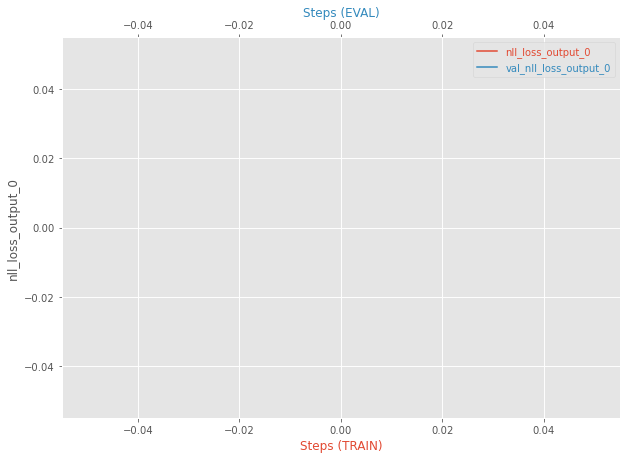

In [113]:
tensor = trial.tensor_names()[0]
plot_tensor(trial, tensor)

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint
# TODO: Add your deployment configuration like instance type and number of instances
print("Creating Endpoint")
predictor=estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.t2.medium"
    ) 
print(predictor)

Creating Endpoint
---------!<sagemaker.pytorch.model.PyTorchPredictor object at 0x7f4b9b214b50>


In [188]:
import boto3

session = boto3.Session()

endpoint = session.client("sagemaker").describe_endpoint(EndpointName="pytorch-training-2023-07-30-20-17-40-763")

endpoint

{'EndpointName': 'pytorch-training-2023-07-30-20-17-40-763',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:022761975017:endpoint/pytorch-training-2023-07-30-20-17-40-763',
 'EndpointConfigName': 'pytorch-training-2023-07-30-20-17-40-763',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.8.0-cpu-py3',
     'ResolvedImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference@sha256:7c4c7ea4f0e8cfe25441880fe23ffcac5997c03e00358e4e22567eb160f8537d',
     'ResolutionTime': datetime.datetime(2023, 7, 30, 20, 17, 43, 648000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 1,
   'DesiredInstanceCount': 1}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2023, 7, 30, 20, 17, 43, 84000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 7, 30, 20, 21, 52, 938000, tzinfo=tzlocal()),
 'ResponseM

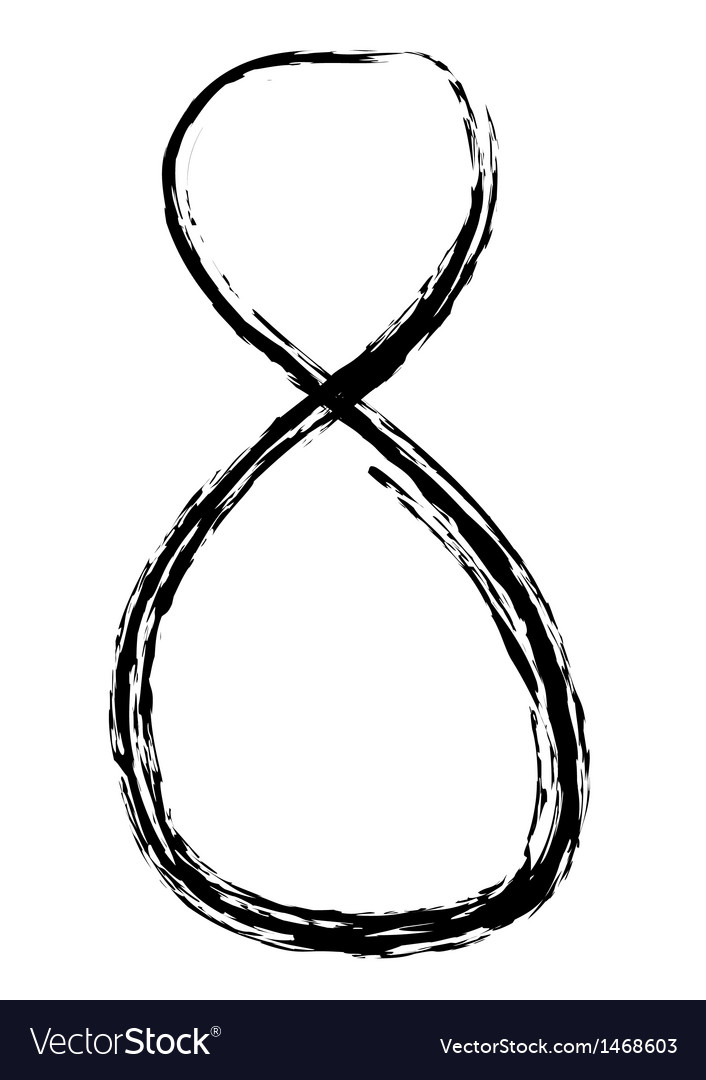

In [216]:
from PIL import Image
import io

test_file = "data/MNIST/testImage.jpeg"
with open(test_file, "rb") as image:
    image = image.read()
    img_bytes = bytearray(image)

Image.open(io.BytesIO(img_bytes))

<ipython-input-242-7a51c1c86ec1>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.array(mask, dtype=np.int)


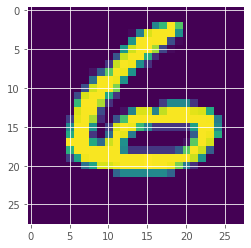

In [242]:
import gzip
import numpy as np
import random
import os
import matplotlib.pyplot as plt

data_dir = "data/MNIST/raw"
with gzip.open(os.path.join(data_dir, "t10k-images-idx3-ubyte.gz"), "rb") as f:
    images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28).astype(np.float32)

mask = random.sample(range(len(images)), 16)  # randomly select some of the test images
mask = np.array(mask, dtype=np.int)
data = images[mask]

plt.imshow(data[1])
plt.show()

In [243]:
response = predictor.predict(np.expand_dims(data, axis=1))
print("Raw prediction result:")
print(response)
print()

labeled_predictions = list(zip(range(10), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

Raw prediction result:
[[-1718.1998291   -846.61553955   -48.09747314  -162.29150391
  -1270.3572998  -1590.32385254 -2214.05297852     0.
   -716.78741455  -825.90722656]
 [-1071.51708984 -1717.4329834  -1362.4909668  -2063.73388672
  -1445.78027344 -1126.86352539     0.         -2471.82495117
   -900.46777344 -1799.55554199]
 [-1417.43041992 -1766.29382324 -1407.04052734 -2372.21166992
  -1348.5291748  -1383.74267578     0.         -2760.58349609
  -1236.36755371 -2265.75488281]
 [-1353.82861328  -739.97021484  -275.01339722  -434.49920654
   -879.6348877  -1237.91345215 -1682.63818359     0.
   -757.76208496  -669.83703613]
 [-1483.79394531     0.          -775.39678955 -1019.37902832
   -738.96936035  -901.90155029  -665.19293213 -1169.75537109
   -646.32019043 -1207.97607422]
 [-1823.54614258 -1036.14904785 -1376.16357422 -1276.
      0.         -1237.59631348 -1461.81835938  -744.08013916
   -835.90856934  -297.87097168]
 [ -954.246521   -1311.84399414  -890.74169922  -698.024230

Prediction: (7, 0.0)


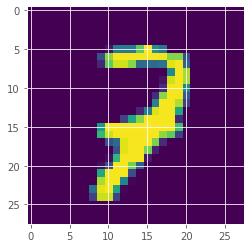

Prediction: (6, 0.0)


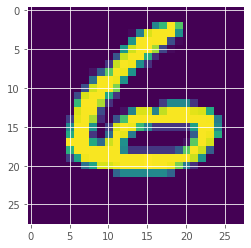

Prediction: (6, 0.0)


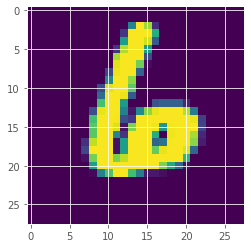

Prediction: (7, 0.0)


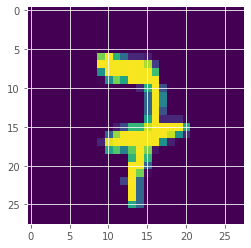

Prediction: (1, 0.0)


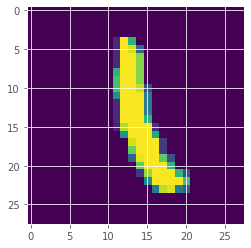

Prediction: (4, 0.0)


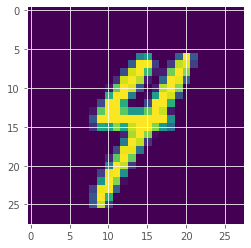

Prediction: (9, 0.0)


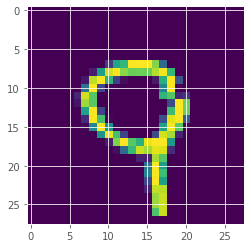

Prediction: (2, 0.0)


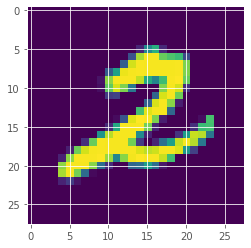

Prediction: (1, 0.0)


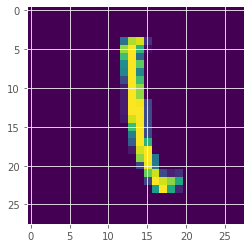

Prediction: (7, 0.0)


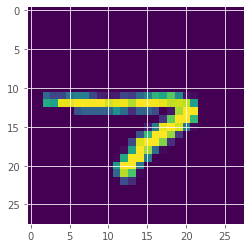

Prediction: (2, 0.0)


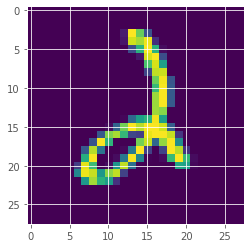

Prediction: (4, 0.0)


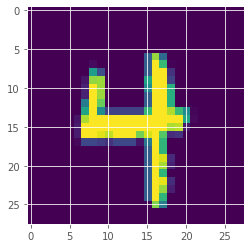

Prediction: (2, 0.0)


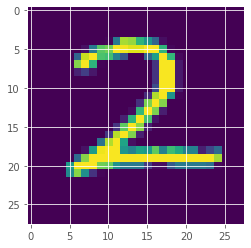

Prediction: (8, 0.0)


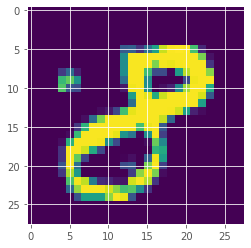

Prediction: (7, 0.0)


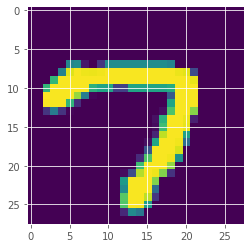

Prediction: (2, 0.0)


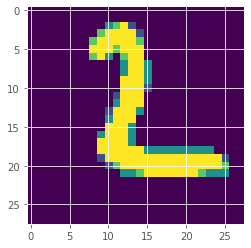

In [263]:
for i in range(len(mask)):
    prediction = list(zip(range(10), response[i]))
    prediction.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
    print("Prediction: {}".format(prediction[0]))
    plt.imshow(data[i])
    plt.show()

In [264]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()